Home Loan Default Prediction

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
loan_data = pd.read_csv('Data/Anonymize_Loan_Default_data.csv', encoding='latin1', index_col=0)

print(loan_data.info())
print(loan_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 38480 entries, 2 to 38480
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38480 non-null  int64  
 1   member_id               38480 non-null  int64  
 2   loan_amnt               38479 non-null  float64
 3   funded_amnt             38479 non-null  float64
 4   funded_amnt_inv         38479 non-null  float64
 5   term                    38480 non-null  object 
 6   int_rate                38480 non-null  float64
 7   installment             38479 non-null  float64
 8   emp_length              37487 non-null  object 
 9   home_ownership          38480 non-null  object 
 10  annual_inc              38478 non-null  float64
 11  verification_status     38480 non-null  object 
 12  issue_d                 38480 non-null  object 
 13  loan_status             38480 non-null  object 
 14  purpose                 38480 non-null  obj

In [3]:
clean_data = loan_data.copy()

clean_data = clean_data.dropna()

# Convert percentage strings to numerical values
clean_data['revol_util'] = clean_data['revol_util'].str.strip('%').astype(float)

# Convert term to numerical values
clean_data['term'] = clean_data['term'].str.extract('(\d+)').astype(int)

# Convert emp_length to numerical values
clean_data['emp_length'] = clean_data['emp_length'].str.extract('(\d+)').astype(float)

# Convert issue_d and last_pymnt_d to datetime
clean_data['issue_d'] = pd.to_datetime(clean_data['issue_d'], format='%b-%y')
clean_data['last_pymnt_d'] = pd.to_datetime(clean_data['last_pymnt_d'], format='%b-%y')


# Encode categorical variables using Label Encoding
label_encoder = LabelEncoder()
categorical_cols = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
for col in categorical_cols:
    clean_data[col] = label_encoder.fit_transform(clean_data[col])

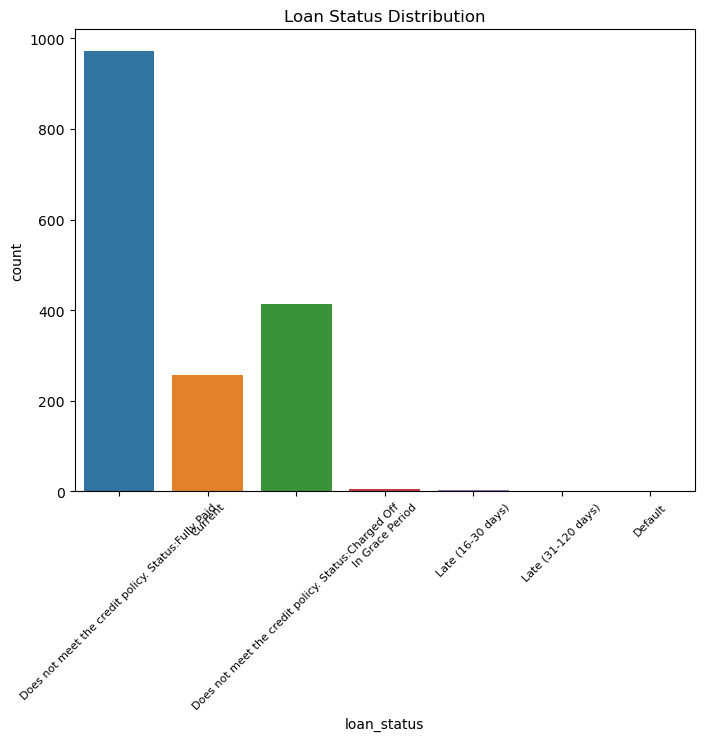

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(data=clean_data, x='loan_status')
plt.title('Loan Status Distribution')
plt.xticks(fontsize=8, rotation=45)
plt.show()

In [5]:
# Removing data which have nothing to do with predictions (id, zip code) or are forward looking such as the loan status, last payment, latest credit, etc.

X = clean_data.drop(['loan_status', 'issue_d', 'last_pymnt_d',
               'last_credit_pull_d', 'earliest_cr_line',
               'next_pymnt_d', 'zip_code', 'repay_fail', 'id', 'member_id'], axis=1)

y = clean_data['repay_fail']


In [6]:
# Scale the X data between 0 and 1

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

preprocessing.minmax_scale(X_scaled, feature_range=(0, 1), axis=0, copy=True)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


# Split the data into test and training data

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=300)


# Use feature selection to determine which features can be removed before modeling

KBest = SelectKBest(score_func = chi2, k = 15)
KBest = KBest.fit(X_train,y_train)

chi_scores = pd.DataFrame({'features': X_train.columns, 'Chi2Score': KBest.scores_, 'pValue': KBest.pvalues_ })

chi_scores[chi_scores['pValue'] < 0.05].sort_values(by='Chi2Score', ascending=False)



,features,Chi2Score,pValue
23,total_rec_prncp,39.756585,2.876691e-10
22,total_pymnt_inv,26.920440,2.120049e-07
21,total_pymnt,25.229167,5.090649e-07
3,term,18.742239,1.496311e-05
25,last_pymnt_amnt,11.964669,5.421884e-04
24,total_rec_int,10.842598,9.919147e-04
9,verification_status,10.802504,1.013629e-03
2,funded_amnt_inv,7.899530,4.944764e-03


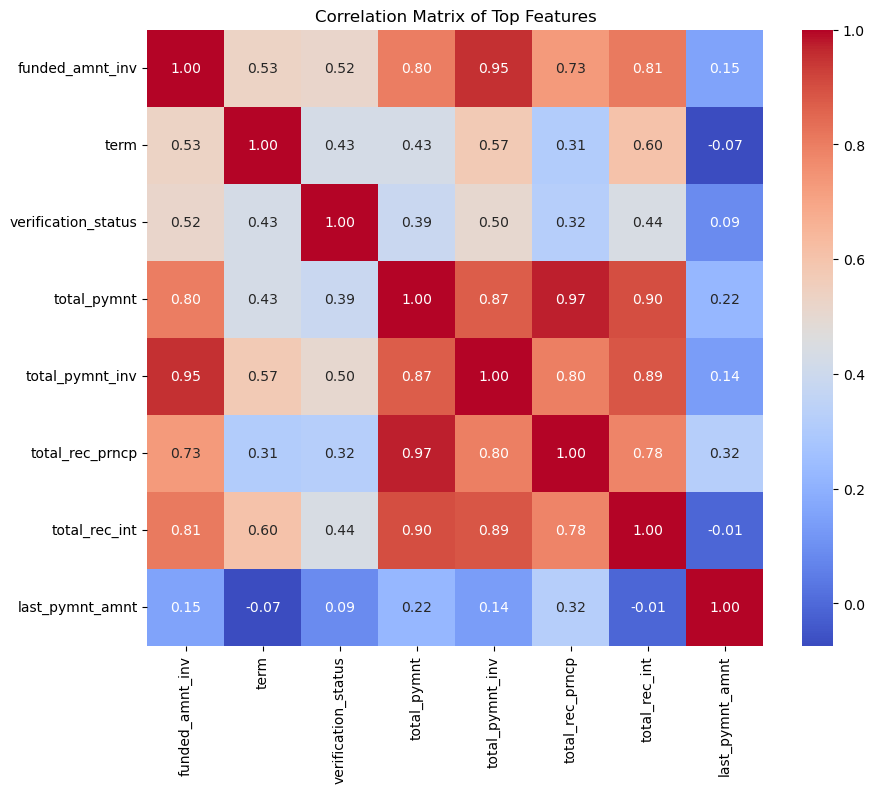

In [7]:
top_features = chi_scores['features'][chi_scores['pValue'] < 0.05].tolist()


# Filter the features in X to include only the top features
X_train_top_features = X_train[top_features]

X_test_top_features = X_test[top_features]

# Compute the correlation matrix
correlation_matrix = X_train_top_features.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Top Features')
plt.show()

In [8]:

# A list of models which could be possible good fits to compare

models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier()),
    ('AdaBoost', AdaBoostClassifier())
]

results = {}

for name, model in models:
    pipeline = Pipeline([
        ('model', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train_top_features, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test_top_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Classification report
    report = classification_report(y_test, y_pred)
    
    # Store results
    results[name] = {'accuracy': accuracy, 'classification_report': report}

for model, result in results.items():
    print(model)
    print("Accuracy:", result['accuracy'])
    print("Classification Report:\n", result['classification_report'])
    print("\n")

Logistic Regression
Accuracy: 0.8719806763285024
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       318
           1       0.88      0.52      0.65        96

    accuracy                           0.87       414
   macro avg       0.87      0.75      0.79       414
weighted avg       0.87      0.87      0.86       414



Random Forest
Accuracy: 0.9468599033816425
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       318
           1       0.94      0.82      0.88        96

    accuracy                           0.95       414
   macro avg       0.94      0.90      0.92       414
weighted avg       0.95      0.95      0.95       414



XGBoost
Accuracy: 0.9565217391304348
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       318
           1       0.93      0.8